In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### Peep into a file

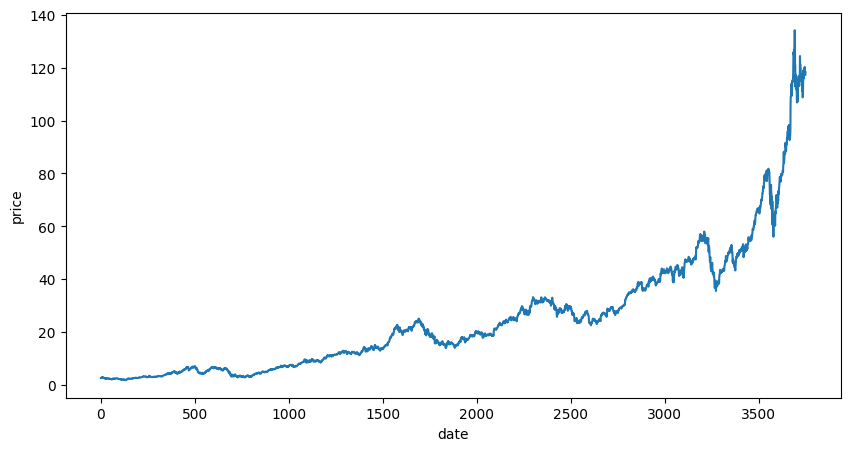

In [6]:
#df = pd.read_csv(os.path.join("./stockprice", "AAPL.csv"))
df = pd.read_csv("https://raw.githubusercontent.com/nongaussian/class-2026-lginnotek-llm/refs/heads/main/stockprice/AAPL.csv")

plt.figure(figsize=(10,5))
plt.plot(df['Close'])
plt.xlabel("date")
plt.ylabel("price")
plt.show()

In [7]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2006-01-03,2.669643,2.580357,2.585000,2.669643,807234400.0,2.284267
1,2006-01-04,2.713571,2.660714,2.683214,2.677500,619603600.0,2.290990
2,2006-01-05,2.675000,2.633929,2.672500,2.656429,449422400.0,2.272961
3,2006-01-06,2.739286,2.662500,2.687500,2.725000,704457600.0,2.331634
4,2006-01-09,2.757143,2.705000,2.740357,2.716071,675040800.0,2.323994


### Setting for preprocessing

In [8]:
split_fraction = 0.75
train_split = int(split_fraction * int(df.shape[0]))

sequence_length = 60
future = 5
learning_rate = 0.001
epochs = 50

features = df[['High', 'Low', 'Open', 'Close', 'Volume']]

In [9]:
# early 0.75 days of records will be used for training
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [10]:
train_data.shape

(2811, 5)

In [11]:
val_data.shape

(938, 5)

In [12]:
x_train = train_data.values
pred_start = sequence_length + future
pred_end = pred_start + train_split
y_train = features.iloc[pred_start:pred_end][['High']].values

x_test = val_data.values[:-sequence_length-future-1]
y_test = features.iloc[train_split+sequence_length+future+1:][['High']].values

In [13]:
print(type(x_train), x_train.shape)

<class 'numpy.ndarray'> (2811, 5)


In [14]:
print(type(y_train), y_train.shape)

<class 'numpy.ndarray'> (2811, 1)


In [15]:
print(type(x_test), x_test.shape)

<class 'numpy.ndarray'> (872, 5)


In [16]:
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (872, 1)


In [17]:
def timeseries_dataset_from_array(x, y, sequence_length):
    """Create sequences from time series data"""
    sequences = []
    targets = []
    for i in range(len(x) - sequence_length + 1):
        sequences.append(x[i:i + sequence_length])
        if y is not None and i < len(y):
            targets.append(y[i])
    return np.array(sequences), np.array(targets) if y is not None else None

x_train_seq, y_train_seq = timeseries_dataset_from_array(x_train, y_train, sequence_length)

In [19]:
print("x_train_seq shape:", x_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
#print("Sample x_batch:")
#print(x_train_seq[0])
#print("Sample y_batch:")
#print(y_train_seq[0])

x_train_seq shape: (2752, 60, 5)
y_train_seq shape: (2752, 1)


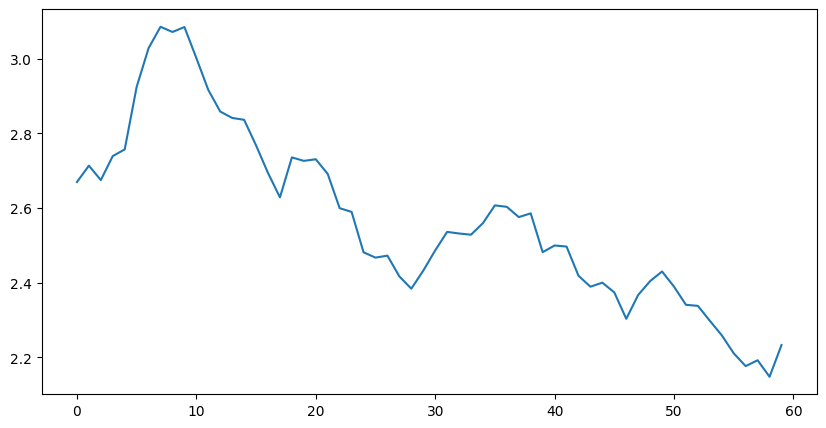

In [20]:
plt.figure(figsize=(10,5))
plt.plot(x_train_seq[0, :, 0])
plt.show()

In [21]:
def normalize_sequence(x_batch, y_batch):
    """Normalize sequences using mean and std computed per sequence"""
    # x_batch: (batch, seq_len, features)
    data_mean = np.mean(x_batch, axis=1, keepdims=True)  # (batch, 1, features)
    data_std = np.std(x_batch, axis=1, keepdims=True)    # (batch, 1, features)
    data_std = np.where(data_std == 0, 1, data_std)  # Avoid division by zero
    
    x_normalized = (x_batch - data_mean) / data_std
    y_normalized = (y_batch - data_mean[:, 0, 0:1]) / data_std[:, 0, 0:1]
    
    return x_normalized, y_normalized

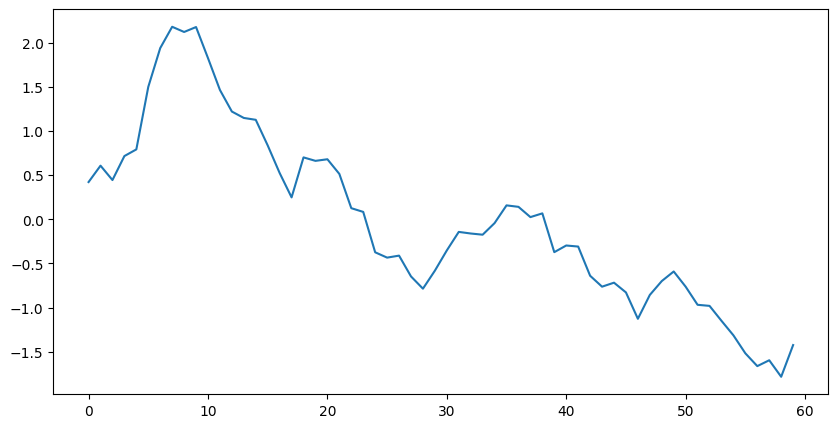

In [22]:
x_norm, y_norm = normalize_sequence(x_train_seq, y_train_seq)
plt.figure(figsize=(10,5))
plt.plot(x_norm[0, :, 0])
plt.show()

In [23]:
x_train_normalized, y_train_normalized = normalize_sequence(x_train_seq, y_train_seq)

In [24]:
x_train_normalized.shape

(2752, 60, 5)

In [25]:
y_train_normalized.shape

(2752, 1)

### In summary...

In [26]:
items = ['AAPL', 'IBM', 'INTC', 'AMD', 'MSFT']
#item_dfs = [ pd.read_csv(os.path.join("./stockprice", f"{i}.csv")) for i in items ]
item_dfs = [ pd.read_csv(f"https://raw.githubusercontent.com/nongaussian/class-2026-lginnotek-llm/refs/heads/main/stockprice/{i}.csv") for i in items ]

split_fraction = 0.75
train_split = int(split_fraction * int(item_dfs[0].shape[0]))

sequence_length = 60
future = 5

In [ ]:
# normalize_sequence is already defined above

In [27]:
def preprocessing_datasets(df):
    features = df[['High', 'Low', 'Open', 'Close', 'Volume']]
    
    train_data = features.loc[0 : train_split - 1]
    val_data = features.loc[train_split:]
    
    x_train = train_data.values
    pred_start = sequence_length + future
    pred_end = pred_start + train_split
    y_train = features.iloc[pred_start:pred_end][['High']].values

    x_test = val_data.values[:-sequence_length-future-1]
    y_test = features.iloc[train_split+sequence_length+future+1:][['High']].values
    
    # Create sequences
    x_train_seq, y_train_seq = timeseries_dataset_from_array(x_train, y_train, sequence_length)
    x_test_seq, y_test_seq = timeseries_dataset_from_array(x_test, y_test, sequence_length)
    
    # Normalize
    x_train_norm, y_train_norm = normalize_sequence(x_train_seq, y_train_seq)
    x_test_norm, y_test_norm = normalize_sequence(x_test_seq, y_test_seq)
    
    return x_train_norm, y_train_norm, x_test_norm, y_test_norm

In [28]:
results = [preprocessing_datasets(df) for df in item_dfs]

In [29]:
x_train_list, y_train_list = [], []
for x_tr, y_tr, _, _ in results:
    x_train_list.append(x_tr)
    y_train_list.append(y_tr)
    
x_train = np.concatenate(x_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

In [30]:
x_train.shape

(13760, 60, 5)

In [31]:
y_train.shape

(13760, 1)

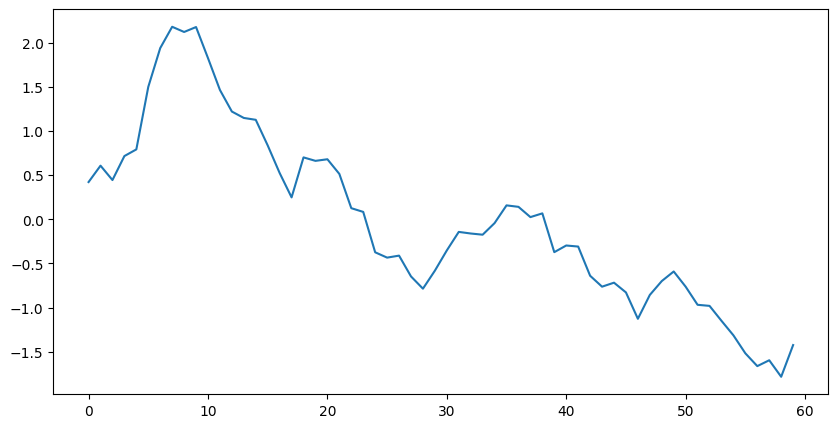

In [32]:
plt.figure(figsize=(10,5))
plt.plot(x_train[0, :, 0])
plt.show()

In [33]:
x_test_list, y_test_list = [], []
for _, _, x_te, y_te in results:
    x_test_list.append(x_te)
    y_test_list.append(y_te)
    
x_test = np.concatenate(x_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

In [34]:
x_test.shape

(4065, 60, 5)

In [35]:
y_test.shape

(4065, 1)

### Save arrays

In [36]:
np.savez('stockprice5_pytorch', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

### Defining recurrent layers

In [34]:
input_dim = 5
n_rnn_layers = 6
x_dims = 64
latent_dims = 64

In [35]:
class SimpleRNNLayer(nn.Module):
    def __init__(self, x_dims, latent_dims, dropout=0.2):
        super(SimpleRNNLayer, self).__init__()
        self.fc_h = nn.Linear(x_dims + latent_dims, latent_dims)
        self.fc_x = nn.Linear(latent_dims, x_dims)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, h_prev):
        xh_concat = torch.cat([x, h_prev], dim=-1)
        h = F.relu(self.fc_h(xh_concat))
        x_next = F.relu(self.fc_x(h))
        x_next = self.dropout(x_next)
        return x_next, h

In [36]:
class Encoder(nn.Module):
    def __init__(self, input_dim, x_dims, latent_dims, n_rnn_layers):
        super(Encoder, self).__init__()
        self.n_rnn_layers = n_rnn_layers
        self.latent_dims = latent_dims
        
        self.input_fc = nn.Linear(input_dim, x_dims)
        self.rnn_layers = nn.ModuleList([
            SimpleRNNLayer(x_dims, latent_dims) for _ in range(n_rnn_layers)
        ])
        
    def forward(self, x, h_prevs):
        """
        x: (batch, input_dim)
        h_prevs: list of (batch, latent_dims) tensors, one for each layer
        """
        x_next = F.relu(self.input_fc(x))
        h_new = []
        
        for i, rnn_layer in enumerate(self.rnn_layers):
            x_next, h = rnn_layer(x_next, h_prevs[i])
            h_new.append(h)
            
        return h_new

In [37]:
encoder = Encoder(input_dim, x_dims, latent_dims, n_rnn_layers).to(device)
print(encoder)

Encoder(
  (input_fc): Linear(in_features=5, out_features=64, bias=True)
  (rnn_layers): ModuleList(
    (0-5): 6 x SimpleRNNLayer(
      (fc_h): Linear(in_features=128, out_features=64, bias=True)
      (fc_x): Linear(in_features=64, out_features=64, bias=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
)


In [38]:
# Print model summary
total_params = sum(p.numel() for p in encoder.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 74880


In [39]:
# Output shape info
print(f"Output: {n_rnn_layers} tensors of shape (batch, {latent_dims})")

Output: 6 tensors of shape (batch, 64)


In [40]:
# Test if encoder works
tmp_x_batch = torch.randn(32, input_dim).to(device)
tmp_h = [torch.zeros(32, latent_dims).to(device) for _ in range(n_rnn_layers)]
output = encoder(tmp_x_batch, tmp_h)
print("Encoder output shapes:", [h.shape for h in output])

Encoder output shapes: [torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([32, 64])]


In [41]:
class Regressor(nn.Module):
    def __init__(self, latent_dims, n_rnn_layers):
        super(Regressor, self).__init__()
        self.fc = nn.Linear(latent_dims * n_rnn_layers, 1)
        
    def forward(self, x):
        return self.fc(x)

In [42]:
regressor = Regressor(latent_dims, n_rnn_layers).to(device)
print(regressor)

Regressor(
  (fc): Linear(in_features=384, out_features=1, bias=True)
)


In [43]:
# Test if regressor works
tmp_h = torch.randn(32, latent_dims * n_rnn_layers).to(device)
output = regressor(tmp_h)
print("Regressor output shape:", output.shape)

Regressor output shape: torch.Size([32, 1])


In [44]:
def forward_rnn(x_batch, encoder, regressor, training=True):
    """
    x_batch: (batch, seq_len, input_dim)
    """
    batch_size = x_batch.shape[0]
    seq_len = x_batch.shape[1]
    
    # Initialize hidden states
    h = [torch.zeros(batch_size, latent_dims).to(x_batch.device) for _ in range(n_rnn_layers)]
    
    # Process each time step
    for i in range(seq_len):
        h = encoder(x_batch[:, i, :], h)
    
    # Concatenate all hidden states and pass through regressor
    h_concat = torch.cat(h, dim=-1)
    return regressor(h_concat)

In [45]:
# Test if forward_rnn works
test_x_batch = torch.randn(32, sequence_length, input_dim).to(device)
output = forward_rnn(test_x_batch, encoder, regressor)
print("Forward RNN output shape:", output.shape)

Forward RNN output shape: torch.Size([32, 1])


### Loss function

In [46]:
criterion = nn.L1Loss()  # Mean Absolute Error (MAE)

### Training

In [47]:
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(regressor.parameters()), 
    lr=1e-5
)

In [48]:
batch_size = 128
epochs = 50

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    start = time.time()
    encoder.train()
    regressor.train()
    
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        
        y_pred = forward_rnn(x_batch, encoder, regressor, training=True)
        loss = criterion(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    # Evaluate on test set
    encoder.eval()
    regressor.eval()
    with torch.no_grad():
        y_test_pred = forward_rnn(x_test_tensor, encoder, regressor, training=False)
        test_loss = criterion(y_test_pred, y_test_tensor)
    
    print(f'Time for epoch {epoch + 1} is {time.time() - start:.2f} sec: loss = {test_loss.item():.6f}')

Time for epoch 1 is 27.66 sec: loss = 1.520679
Time for epoch 2 is 27.21 sec: loss = 1.486985
Time for epoch 3 is 26.64 sec: loss = 1.448458
Time for epoch 4 is 26.28 sec: loss = 1.399807
Time for epoch 5 is 25.09 sec: loss = 1.337635
Time for epoch 6 is 26.44 sec: loss = 1.253319
Time for epoch 7 is 25.32 sec: loss = 1.137081
Time for epoch 8 is 25.00 sec: loss = 0.993369
Time for epoch 9 is 25.54 sec: loss = 0.894714
Time for epoch 10 is 25.17 sec: loss = 0.872766
Time for epoch 11 is 25.15 sec: loss = 0.866499
Time for epoch 12 is 24.77 sec: loss = 0.862342
Time for epoch 13 is 25.14 sec: loss = 0.857584
Time for epoch 14 is 25.57 sec: loss = 0.856040
Time for epoch 15 is 25.60 sec: loss = 0.852366
Time for epoch 16 is 25.29 sec: loss = 0.852393
Time for epoch 17 is 26.08 sec: loss = 0.850338
Time for epoch 18 is 25.62 sec: loss = 0.847695
Time for epoch 19 is 26.61 sec: loss = 0.846246
Time for epoch 20 is 25.23 sec: loss = 0.844687
Time for epoch 21 is 25.75 sec: loss = 0.843481
T

KeyboardInterrupt: 

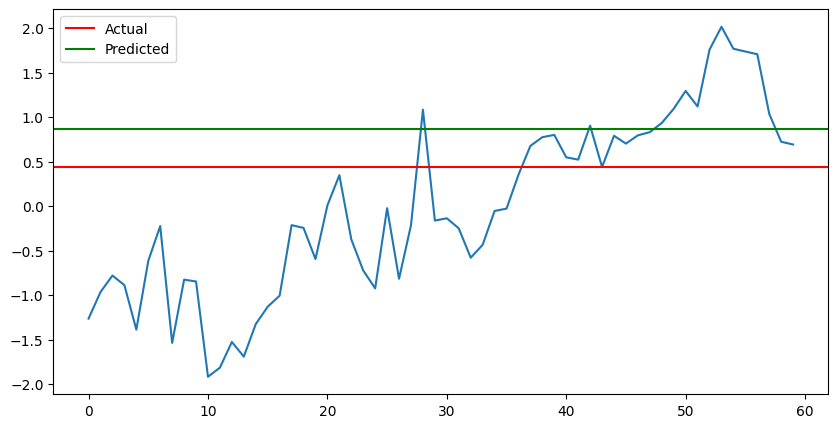

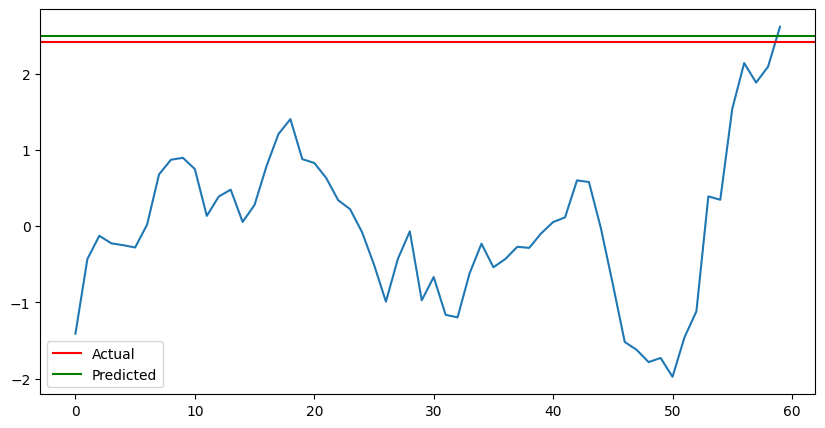

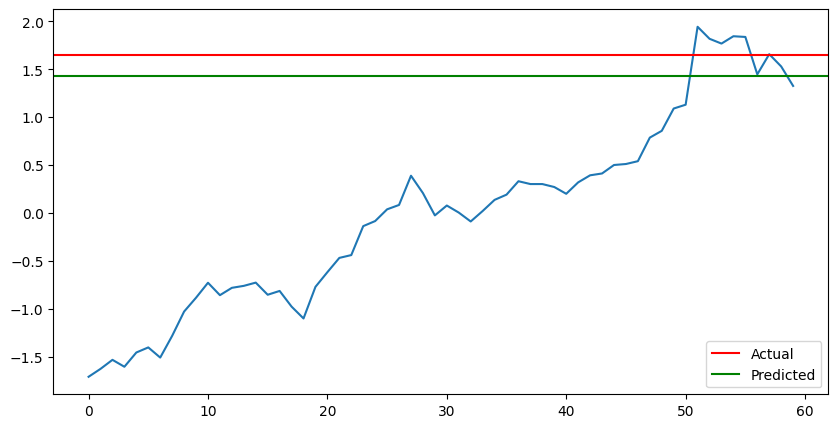

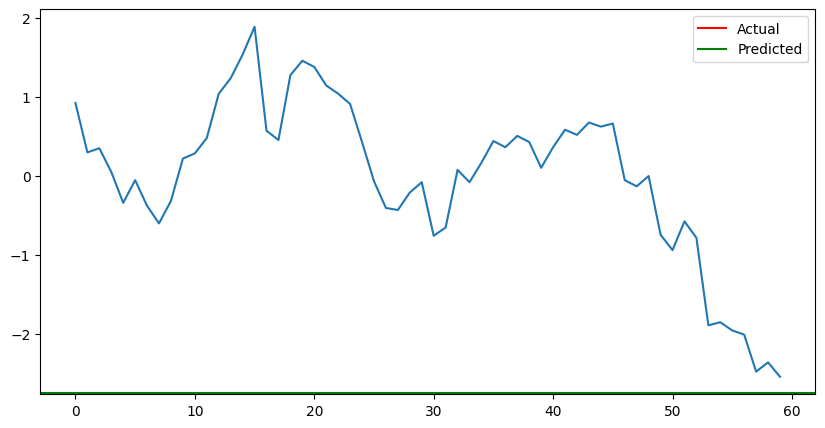

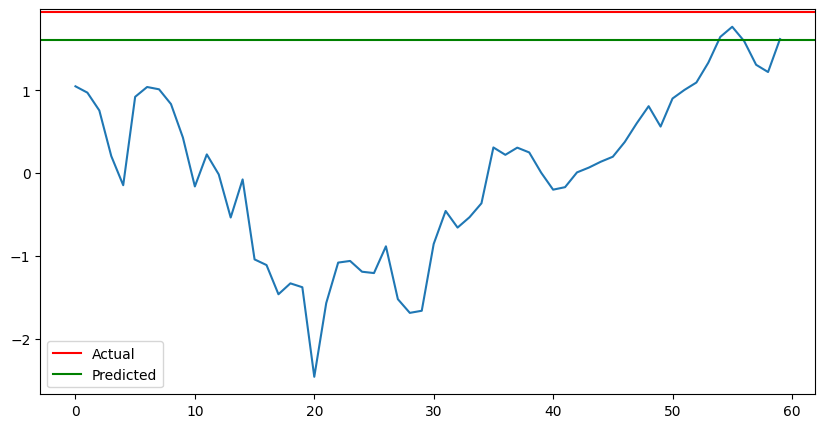

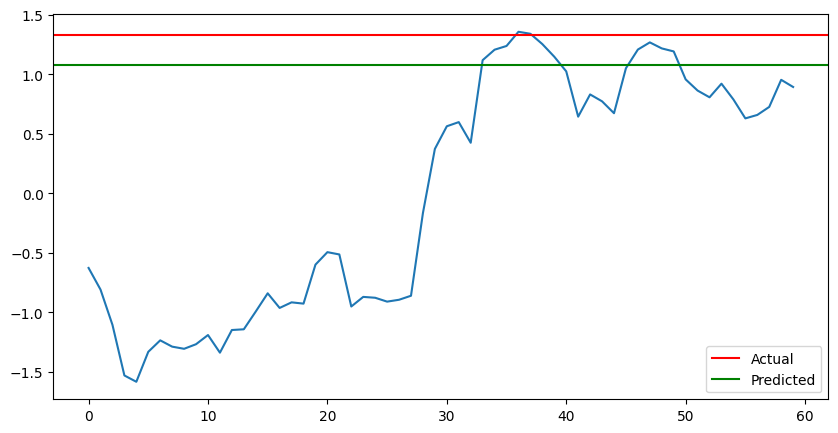

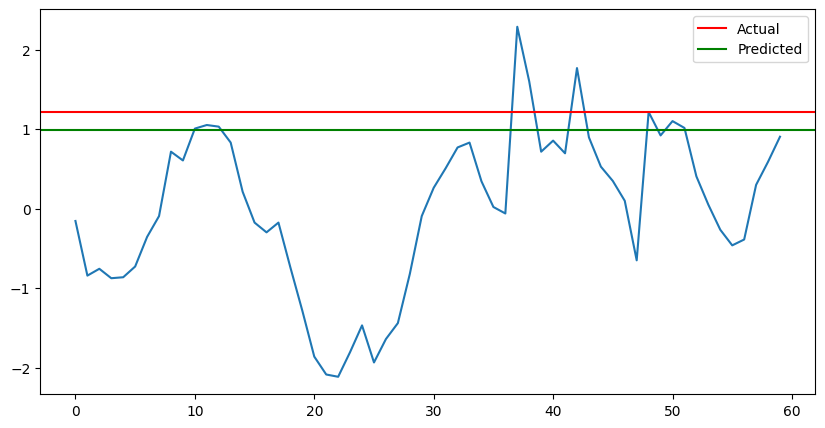

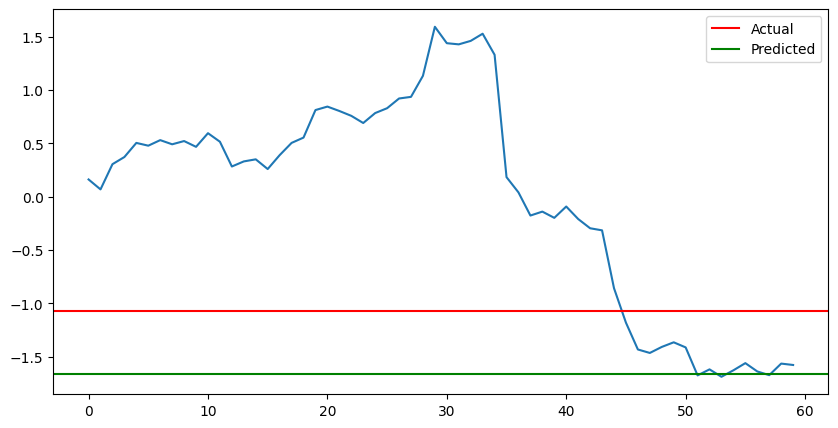

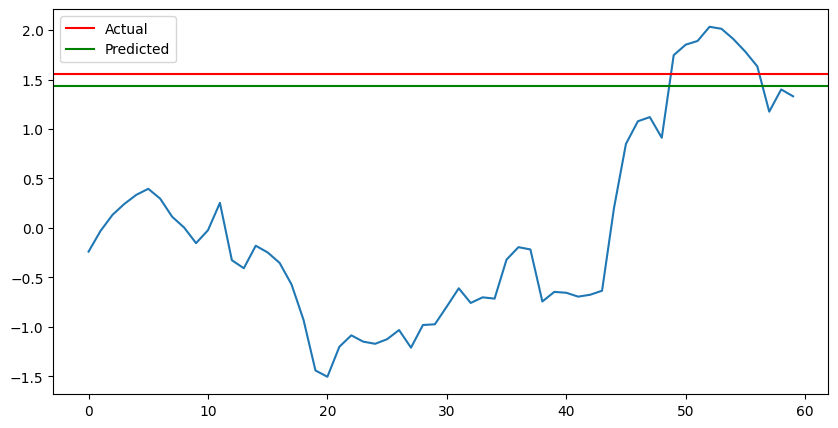

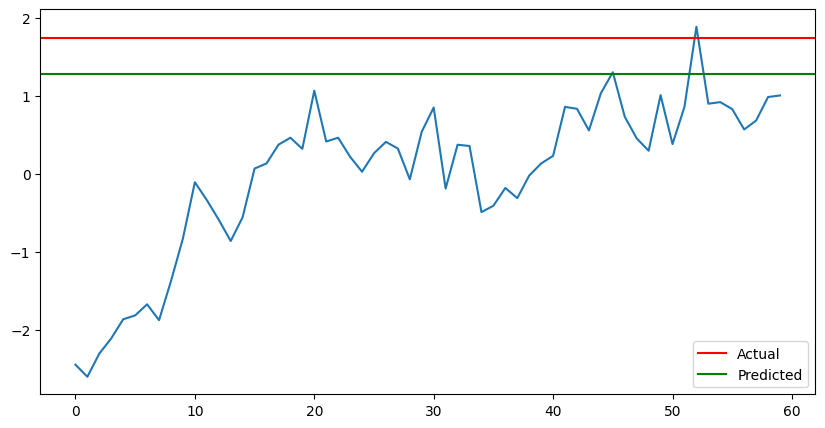

In [49]:
encoder.eval()
regressor.eval()

for _ in range(10):
    idx = np.random.randint(x_test.shape[0])
    x_sample = torch.tensor(x_test[idx:idx+1], dtype=torch.float32).to(device)
    
    with torch.no_grad():
        y_pred = forward_rnn(x_sample, encoder, regressor, training=False)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_test[idx, :, 0])
    plt.axhline(y_test[idx, 0], color='r', label='Actual')
    plt.axhline(y_pred.cpu().numpy()[0, 0], color='g', label='Predicted')
    plt.legend()
    plt.show()